# 结果展示

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time
import os

from utils import config
from utils.backtest import *

/home/david/miniconda3/envs/stock_rl/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


## 数据读取

In [2]:
root_path = os.getcwd()
root_path = os.path.join(root_path, "learn", "trade_file")
print("root_path: ", root_path)
data_file_path = os.path.join(os.getcwd(), "learn", "data_file")
mode = 1
if mode == 1:
    test_file = os.path.join(data_file_path, "stock_info_test.csv")
else:
    test_file = os.path.join(data_file_path, "trade.csv")
test_pd = pd.read_csv(test_file)
start_date = test_pd['date'].min().replace("-", "")
end_date = test_pd['date'].max().replace("-", "")
print(start_date, end_date)

root_path:  /home/david/MF/github/StockRL/learn/trade_file
20241018 20241118


In [3]:
model_list = ["a2c", "ppo", "td3", "ddpg", "sac"]
path_dict = {}
for model in model_list:
    path_dict[model] = os.path.join(root_path, "account_value_{}.csv".format(model))

In [4]:
account_value_dict = {}
for m in model_list:
    account_value_dict[m] = pd.read_csv(path_dict[m])

## 获取 baseline 的结果

In [5]:
get_baseline_func = lambda: get_baseline(config.SSE_50_INDEX, 
              start=start_date,
              end=end_date)
baseline_csv_file = root_path + os.sep + f"baseline_sse50_{start_date}_{end_date}.csv"
baseline_df = get_baseline_from_file(baseline_csv_file, get_baseline_func)

In [6]:
baseline_stats = backtest_stats(baseline_df, value_col_name='close')

Annual return           0.446220
Cumulative returns      0.032735
Annual volatility       0.182862
Sharpe ratio            2.201724
Calmar ratio           13.651711
Stability               0.154583
Max drawdown           -0.032686
Omega ratio             1.496847
Sortino ratio           4.276257
Skew                         NaN
Kurtosis                     NaN
Tail ratio              1.795995
Daily value at risk    -0.021441
dtype: float64


In [7]:
start_close_value = baseline_df.iloc[0]['close']
baseline_df['processed_close'] = ((baseline_df['close'] - start_close_value)/start_close_value + 1) * 1e+6

In [8]:
baseline_df.head()

,tic,date,open,high,low,close,volume,day,processed_close
0,000016.SH,2024-10-18,2681.9116,2606.3767,2722.6463,2583.4892,70198207.0,4,1.000000e+06
1,000016.SH,2024-10-21,2681.0567,2694.9659,2701.3576,2659.6650,72042226.0,0,1.029486e+06
2,000016.SH,2024-10-22,2692.6613,2672.8534,2704.3458,2672.4493,52208167.0,1,1.034434e+06
3,000016.SH,2024-10-23,2708.0459,2691.1255,2728.2578,2682.9420,56076797.0,2,1.038496e+06
4,000016.SH,2024-10-24,2680.7044,2695.3790,2698.9996,2669.7099,42253335.0,3,1.033374e+06


## 展示最终的结果

In [9]:
data = {
    m: account_value_dict[m]['total_assets'] for m in model_list
}
data['baseline'] = baseline_df['processed_close']
result_account_value = pd.DataFrame(data = data)

In [10]:
result_account_value = result_account_value.iloc[:-1].apply(lambda x : (x - 1e+6)/1e+6)

In [11]:
result_account_value.tail()

,a2c,ppo,td3,ddpg,sac,baseline
16,0.008442,0.007260,0.042525,0.032686,0.025965,0.049651
17,0.003593,0.002507,0.023776,0.024504,0.013916,0.045721
18,0.007425,0.006208,0.034453,0.032945,0.014016,0.043816
19,0.003258,0.000381,0.017129,0.026142,0.001609,0.045177
20,0.000930,-0.004348,0.002810,0.017019,-0.015848,0.034048


In [12]:
result_account_value.to_csv(os.path.join(root_path, "result_account_value.csv"), index=False)

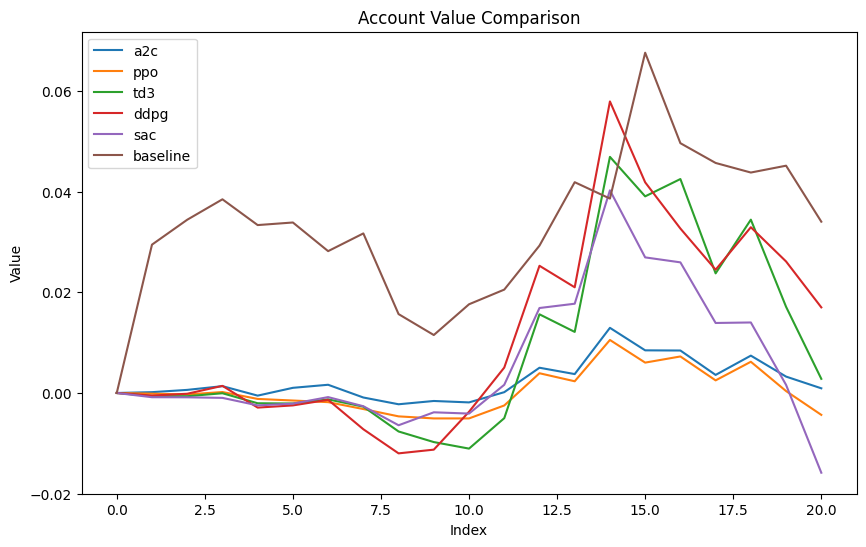

In [13]:
plt.figure(figsize=(10, 6))
for col in result_account_value.columns:
    plt.plot(result_account_value.index, result_account_value[col], label=col)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Account Value Comparison')
plt.legend()
plt.show()

## 展示回测结果

In [14]:
print("和 {} 指数进行比较".format(config.SSE_50_INDEX[0]))
cmp_data = backtest_plot_from_file(baseline_csv_file, get_baseline_func, 
                        account_value_dict,
                        value_col_name = 'total_assets')
df = pd.DataFrame(cmp_data).T
df

和 000016.SH 指数进行比较


,累计收益率,最大回撤率,年化收益率,年化波动率,Sharpe比率,Omega比率
baseline,3.27%,-3.27%,44.62%,17.85%,249.93%,149.68%
a2c,0.09%,-1.19%,1.12%,5.13%,21.88%,104.49%
ppo,-0.43%,-1.47%,-5.10%,5.46%,-93.37%,84.20%
td3,0.28%,-4.21%,3.42%,18.36%,18.65%,105.72%
ddpg,1.70%,-3.87%,22.45%,17.73%,126.62%,127.00%
sac,-1.58%,-5.40%,-17.44%,13.89%,-125.60%,76.06%
